In [4]:

# import glob
import os
import pandas as pd
# import random
import sys
sys.path.insert(0, '../src/')

from helper import ImageAnalysis, plot_feature_colors
import glob

import random
# import cv2
import numpy as np
import pickle

import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# from sklearn import preprocessing

from shap import TreeExplainer, summary_plot, decision_plot
# # from mpl_toolkits.mplot3d import Axes3D
# # from sklearn.cluster import KMeans

# # import matplotlib.pyplot as plt
# # from matplotlib.colors import to_rgba_array

# # import sys
# # sys.path.insert(0, '../src')

# # from IPython.display import display, HTML

# # from helper import *

%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
with open('../models/buckets_8_4.pkl', 'rb') as f:
            buckets = pickle.load(f)

# Descriptive Analysis and Interactive way to train with Classifiers

In [6]:
N_COLORS = 16
N_PIXELS_DIM = 4
data_path = '../../../surfdrive/datasets/Colors/OrientalColorData/'



# Loading data
Here we load and prepare the data for exploration and analysis

In [7]:
meta_ac = pd.read_csv('../data/processed/autochrome_metadata.csv', delimiter='\t')
meta_pc = pd.read_csv('../data/processed/photochrome_metadata.csv', delimiter='\t')

# Convert 'location' column to lowercase
meta_ac['location'] = meta_ac['location'].str.lower()
meta_pc['location'] = meta_pc['location'].str.lower()

# Add 'type' column
meta_ac['type'] = 'ac'
meta_pc['type'] = 'pc'

# Concatenate the two DataFrames
meta = pd.concat([meta_ac, meta_pc], axis=0)

meta.head()

title         date location  \
0                            Tissage de tapis persan  1 July 1927     iran   
1  Darvaseh-Dowlat, l'une des portes de la ville ...  1 July 1927     iran   
2      Darvaseh-Dowlat, l'une des portes de la ville  1 July 1927     iran   
3  Panorama sur un quartier de la ville, en direc...  1 July 1927     iran   
4              Vue vers le mont Demâvend ou Damavand  1 July 1927     iran   

                               filename  \
0  36e067ba1103d3b4d7f37c2e12f7757f.jpg   
1  92211700123c842b0e745c1fc14e921c.jpg   
2  45341b5d4c11cdcb819430ac8af694dc.jpg   
3  5923652ed3e3ca31a12c6e5e99b688c1.jpg   
4  c0404863501ef86d061211878b8ea237.jpg   

                                                 url type  
0  https://opendata.hauts-de-seine.fr/api/v2/cata...   ac  
1  https://opendata.hauts-de-seine.fr/api/v2/cata...   ac  
2  https://opendata.hauts-de-seine.fr/api/v2/cata...   ac  
3  https://opendata.hauts-de-seine.fr/api/v2/cata...   ac  
4  https://opendata.hauts-de-seine.fr/api/v2/cata...   ac

In [8]:
meta['location'].value_counts()

france         38678
germany         2525
japan           2442
switzerland     2265
belgium         2052
               ...  
luxembourg         4
cuba               4
sri lanka          1
rusia              1
finland            1
Name: location, Length: 70, dtype: int64

France is overrepresented and dropped from collection.


In [9]:
meta = meta[meta['location'] != 'france']

In [10]:
meta.loc[meta['type'] == 'ac']['location'].value_counts()
#meta.loc[meta['type'] == 'ac']['location'].value_counts().plot.bar(title='Autochrome');

japan                     2442
belgium                   1915
greece                    1812
turkey                    1591
switzerland               1479
germany                   1298
afghanistan               1193
algeria                   1177
italy                     1168
iran                      1109
india                     1084
benin                     1048
morocco                    859
canada                     846
uk                         825
egypt                      823
china                      738
iraq                       725
spain                      670
syria                      589
lebanon                    508
tunesia                    419
israel                     413
bosnia and herzegovina     270
netherlands                242
norway                     183
macedonia                  164
sweden                     118
mongolia                    98
albania                     97
jordan                      96
saudi arabia                94
kosovo  

In [11]:
meta.loc[meta['type'] == 'pc']['location'].value_counts()
#meta.loc[meta['type'] == 'pc']['location'].value_counts(normalize=True).plot.bar(title='Photochrome');

germany           1227
uk                1180
switzerland        786
austro-hungary     603
us                 466
italy              319
wales              207
scotland           183
norway             149
holy land          146
belgium            137
ireland            122
netherlands        117
egypt              107
russia              89
algeria             74
india               64
new zealand         61
greece              53
ukraine             44
turkey              44
tunisia             41
australia           35
canada              21
na                  17
singapore           15
denmark             14
argentina           12
south africa        11
czech republic      11
spain                9
roumania             8
china                8
montenegro           7
sweden               7
monaco               7
bahama               6
luxembourg           4
cuba                 4
servia               4
iran                 2
sri lanka            1
morocco              1
rusia      

In [12]:
occident = ["uk", "germany", "switzerland", "belgium", "italy", "austro-hungary", "scotland"]
orient = ['saudi arabia', 'holy land', 'egypt', 'algeria', 'turkey', 'afghanistan', 'iraq', 'syria', 'tunesia', 'israel']

# Filter filenames based on location for autochrome images
occident_ac_imgs = meta_ac[meta_ac['location'].isin(occident)]['filename'].tolist()
orient_ac_imgs = meta_ac[meta_ac['location'].isin(orient)]['filename'].tolist()

# Filter filenames based on location for photochrome images
occident_pc_imgs = meta_pc[meta_pc['location'].isin(occident)]['filename'].tolist()
orient_pc_imgs = meta_pc[meta_pc['location'].isin(orient)]['filename'].tolist()


## Collection Statistics

In [13]:
print('Number of AutoChrome Images: {}'.format(meta_ac.shape[0]))
print('Number of PhotoChrome Images: {}'.format(meta_pc.shape[0]))

print(f'Number of Occident Autochrome images: {len(occident_ac_imgs)}')
print(f'Number of Orient Autochrome images: {len(orient_ac_imgs)}')

print(f'Number of Occident Photochrome images: {len(occident_pc_imgs)}')
print(f'Number of Orient Photochrome images: {len(orient_pc_imgs)}')

ImageAnalysis.country_count(meta_pc, 'germany')
ImageAnalysis.country_count(meta_pc, 'egypt')

Number of AutoChrome Images: 64564
Number of PhotoChrome Images: 7047
Number of Occident Autochrome images: 6685
Number of Orient Autochrome images: 7024
Number of Occident Photochrome images: 4435
Number of Orient Photochrome images: 371
The collection contains 1227 images of germany
The collection contains 107 images of egypt


In [14]:
img_list = glob.glob(data_path + 'images_all/*.jpg')
print(f'Finished Loading {len(img_list)} images...')

Finished Loading 72494 images...


### Random image
Here we plot a random image from the collection and extract its dominant colors using K-means clustering

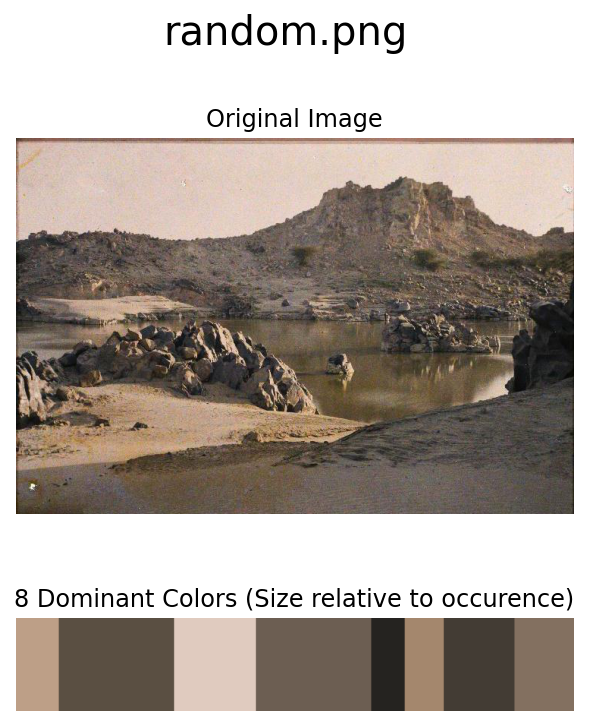

In [46]:
random_img = random.choice(img_list)
ImageAnalysis.plot_color_histogram(random_img, fig_path='../figures/', title='random.png', color_scheme='RGB')

## Example Images

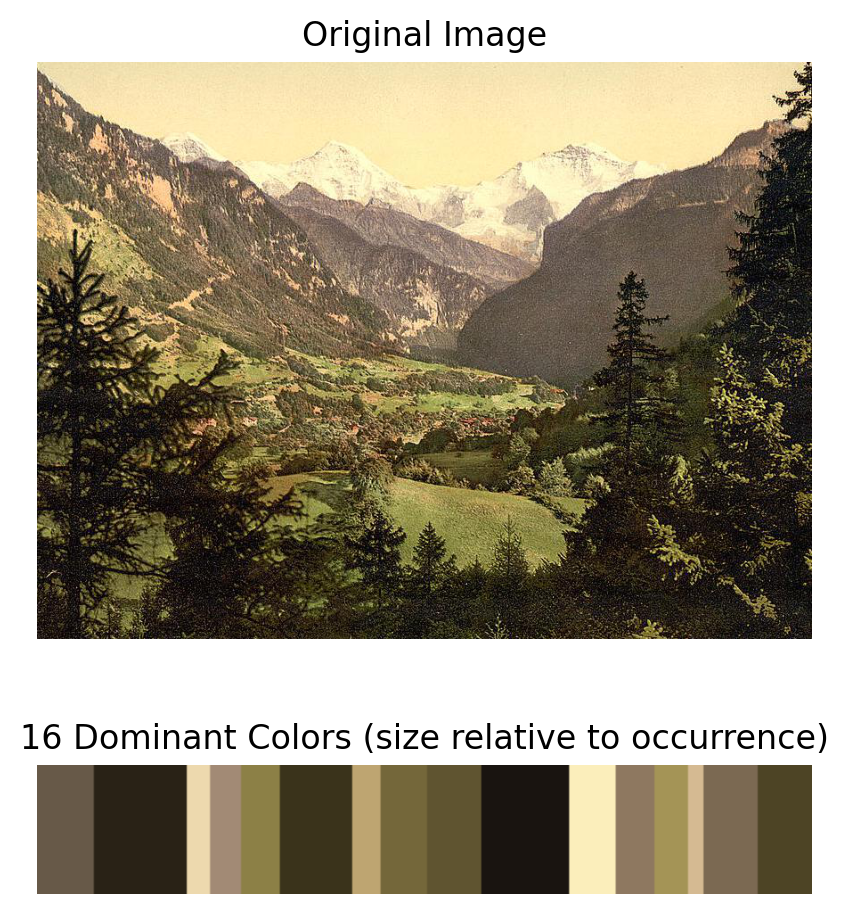

In [57]:
ImageAnalysis.plot_color_histogram(os.path.join(data_path, 'images_all', '2001701280.jpg'), fig_path='../figures/', title='Occident Photochrome', n_dominant_colors=N_COLORS)

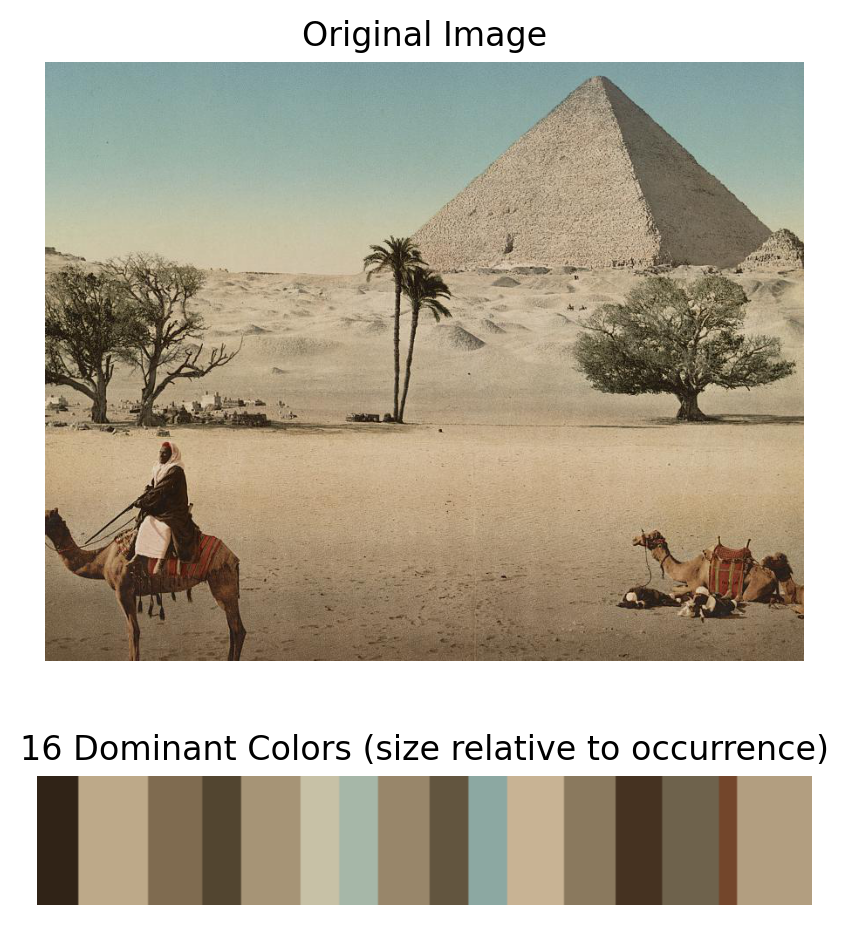

In [58]:
ImageAnalysis.plot_color_histogram(os.path.join(data_path, 'images_all', '2017658153.jpg'), fig_path='../figures/', title='Orient Photochrom', n_dominant_colors=N_COLORS)

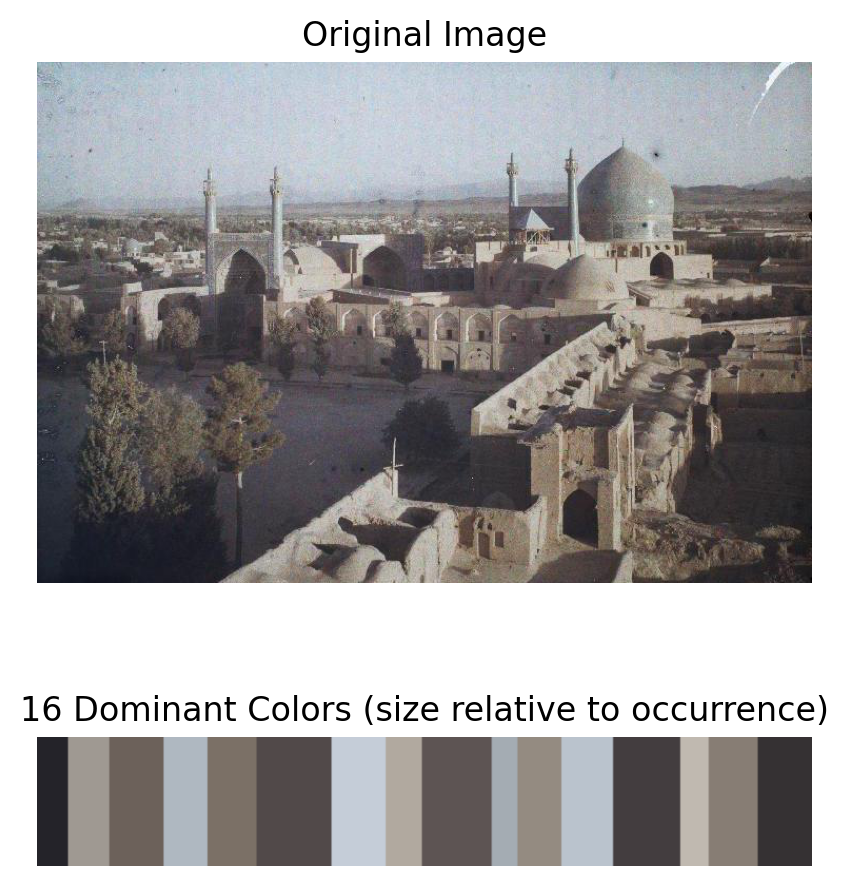

In [59]:
ImageAnalysis.plot_color_histogram(os.path.join(data_path, 'images_all', '0ae95f3496f2c4be954b536c6910d828.jpg'), fig_path='../figures/', title='Orient Autochrome', n_dominant_colors=N_COLORS)

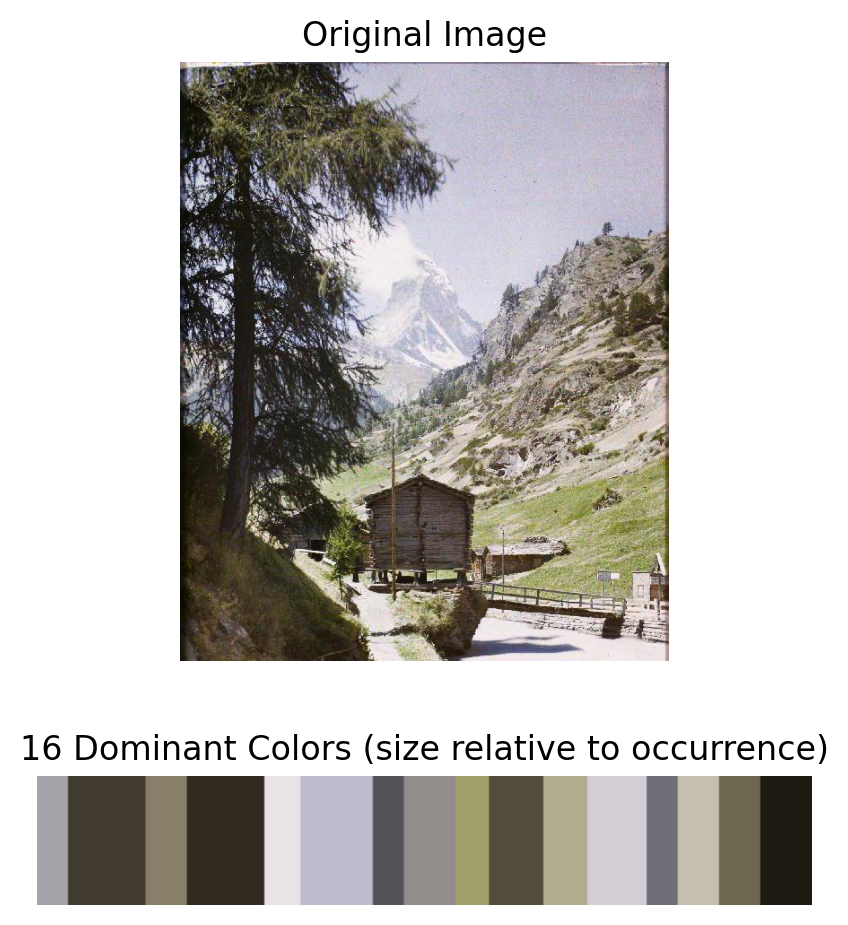

In [60]:
ImageAnalysis.plot_color_histogram(os.path.join(data_path, 'images_all', '0a11bd71e41efdd838510af174c9f008.jpg'), fig_path='../figures/', title='Occident Autochrome', n_dominant_colors=N_COLORS)

## Exploring Classification Algorithm
The bash file uses train_classification to run classification across all collections and settings. Here we have to change things manually.

Possible methods include:
- `ac` - orient vs occident in autochrome
- `pc` - orient vs occident in photochrome
- `all` - autochrome vs photochrome in the collection of orient and occident images

The Buckets have been pretrained using the bash script `run_calculating_buckets.sh`. We now select the hightest number of dominant colors (`16`) and buckets (`8**3`). 


In [20]:
## Preparing the file with buckets

with open('../models/buckets_16_6.pkl', 'rb') as f:


    d = pickle.load(f)

d2 = list()
filenames = list()
for index, x in enumerate(d):
    if x: #check if there is something there
        d_ = {}
        for k, v in x.items():
            if k == 'img':
                filenames.append(v)
            else:
                d_[k] = v['perc']
        d2.append(d_)
    else:
        pass

print('finished preparing buckets file')

finished preparing buckets file


In [21]:
# filtering metadata on images which have been included in the buckets
# turning bucket dictionary into a dataframe

meta = meta[meta['filename'].isin(filenames)]

df = pd.DataFrame.from_dict(d2)
df = df.fillna(0)
df = df.reindex(sorted(df.columns), axis=1)


## Photochrome vs Autochrome

In [22]:
method = 'all'

if method == 'all':
    target = 'type'


else:
    meta = meta[meta['location'].isin(occident) | meta['location'].isin(orient)]
    meta['origin'] = np.where(meta['location'].isin(orient), 'orient', 'occident')
    meta = meta[meta['type'] == method]
    target = 'origin'

df.index = filenames

selected_files = meta['filename'].values
df = df.loc[selected_files]
assert df.shape[0] == meta.shape[0]

In [23]:

cv = 5
test_size = 0.2

feature_list = list(df.columns)
# make train test split
X_train, X_test, y_train, y_test = train_test_split(df, 
                                                    meta[target].values, 
                                                    test_size=test_size, 
                                                    random_state=42, 
                                                    shuffle=True)


# grid search random forest
param_grid = {
             'n_estimators': [5, 10, 15, 20, 50, 100, 200],
             'max_depth': [2, 5, 7, 9]
         }
print('training random forest classifier')
clf = RandomForestClassifier(class_weight = 'balanced')
grid_clf = GridSearchCV(clf, param_grid, cv=cv)
grid_clf.fit(X_train, y_train)
print(f'Accuracy: {grid_clf.score(X_test, y_test)}')

best_clf = grid_clf.best_estimator_


training random forest classifier
Accuracy: 0.9293956878226541


In [27]:
joblib.dump(best_clf, f'../models/clf_{method}_16_6.pkl', compress = 1)

['../models/clf_all_16_6.pkl']

### Explain 

The target variable 0 refers to autochrome and 1 to photochrome, i.e. a positive model effect is directed towards photochrome

In [28]:
explainer = TreeExplainer(best_clf)
shap_values = np.array(explainer.shap_values(X_train))



# plt.savefig("pc_ac_summary_plot.png", dpi=300, bbox_inches='tight')



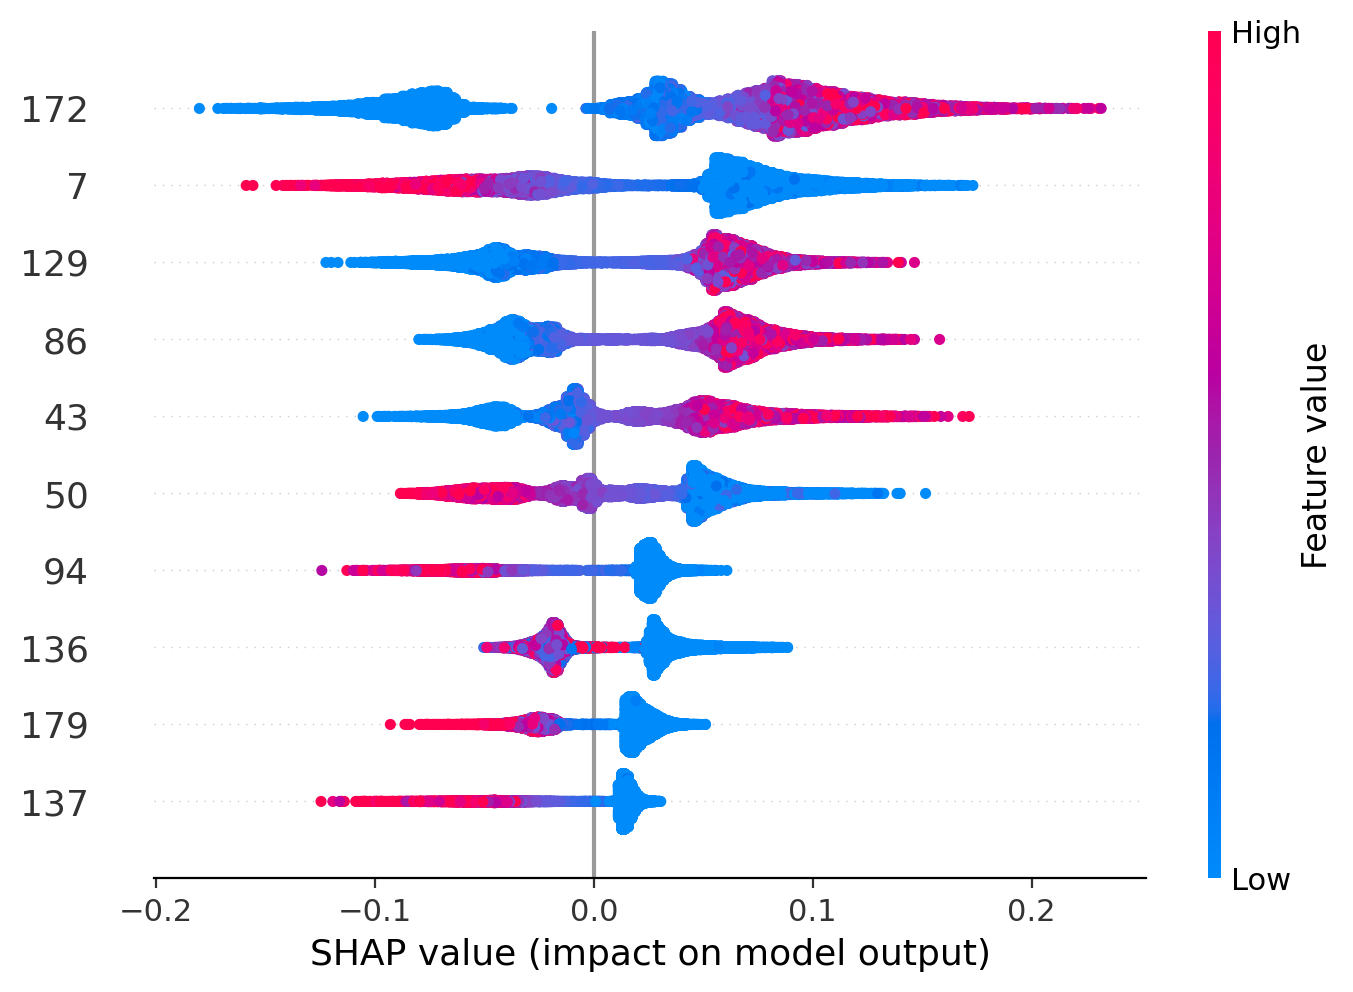

In [29]:
summary_plot(shap_values[0],X_train, max_display=10, show=True)

High feature value indicates a high presence of this dominant color, with a low feature indicative of a low presence. A high value with a high SHAP value, thus a positive impact on model impact is therefore predictive of an photochrome image. 




In [30]:
from train_classifier import Classifier

In [42]:
features = []
for x in d[:5]:
    for k, v in x.items():
        if k == 'img':
            continue
        try:
            features.append(k)
            feature_color = [v['color']]
            avg_feature_color = np.average(feature_color, axis=0)
            print(avg_feature_color)
            #Classifier.plot_and_save_bucket_color(avg_feature_color, feature, title, figures_path, verbose)
        except KeyError:
            print(f'Could not find color info for feature {feature}.')
        except Exception as e:
            print(f'Error while processing feature {feature}: {e}')

[172.21445131 183.54018547 182.54945904]
[135.40980188 151.79770594 153.62669447]
[129.32048375 122.72108844  99.5404384 ]
[51.37878788 47.09090909 26.5       ]
[116.00930233 108.86511628  84.29767442]
[140.83174224 135.44570406 113.81682578]
[160.05669782 175.96635514 178.79813084]
[78.7995338  69.4965035  46.84848485]
[123.02665122 133.05677868 127.58632677]
[167.66906106 173.6613648  165.94561313]
[179.74133333 188.58333333 192.802     ]
[124.19116757 120.22988506 106.53962492]
[150.81388253 152.13501144 142.27154844]
[83.57940327 79.22040423 62.80654475]
[133.47710683 130.65958859 116.35633709]
[159.75125513 170.80739388 174.37425833]
[106.51910299 101.3089701   84.78903654]
[49.75249169 51.74252492 41.88870432]
[167.15762004 173.75365344 168.11847599]
[135.55091185 122.35106383 100.71276596]
[189.44727273 192.21494949 186.53535354]
[109.76891892  97.33648649  76.91216216]
[147.56949662 136.22539444 115.23441022]
[141.63823065 145.83254344 136.27330174]
[42.81481481 48.07407407 25.

In [47]:
[[avg_feature_color / 255]]

[[array([0.44464344, 0.37023999, 0.29891754])]]

In [49]:
Classifier.plot_avg_bucket_colors(d[:5], 'ac_pc', figures_path='../figures/')

[172.21445131 183.54018547 182.54945904]
[135.40980188 151.79770594 153.62669447]
[129.32048375 122.72108844  99.5404384 ]
[51.37878788 47.09090909 26.5       ]
[116.00930233 108.86511628  84.29767442]
[140.83174224 135.44570406 113.81682578]
[160.05669782 175.96635514 178.79813084]
[78.7995338  69.4965035  46.84848485]
[123.02665122 133.05677868 127.58632677]
[167.66906106 173.6613648  165.94561313]
[179.74133333 188.58333333 192.802     ]
[124.19116757 120.22988506 106.53962492]
[150.81388253 152.13501144 142.27154844]
[83.57940327 79.22040423 62.80654475]
[133.47710683 130.65958859 116.35633709]
[159.75125513 170.80739388 174.37425833]
[106.51910299 101.3089701   84.78903654]
[49.75249169 51.74252492 41.88870432]
[167.15762004 173.75365344 168.11847599]
[135.55091185 122.35106383 100.71276596]
[189.44727273 192.21494949 186.53535354]
[109.76891892  97.33648649  76.91216216]
[147.56949662 136.22539444 115.23441022]
[141.63823065 145.83254344 136.27330174]
[42.81481481 48.07407407 25.

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

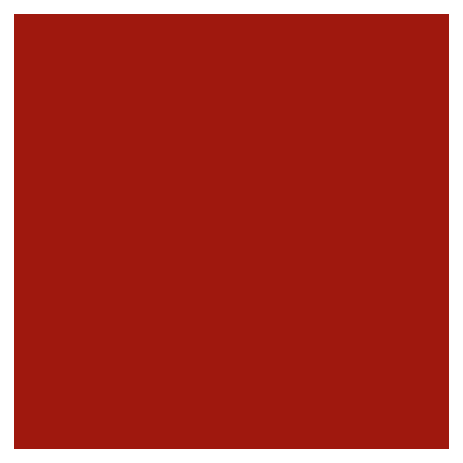

In [73]:
plot_feature_colors(d, 'ac_pc', figures_path='../figures/all/16_6')

# low levels are predictive of photochrome, high levels of photochrome


## Difference orient / occident for autochrome

0 = occident

1 = orient

In [131]:
meta[meta['type'] == 'ac']['origin'].value_counts()
data = meta[meta['type'] == 'ac'].groupby(['origin']).apply(lambda s: s.sample(350))
data['filename'].nunique()

700

In [132]:
clf, X_train, feature_list, d = cluster_colors(data, 'origin', 'or_occ_ac.pkl')

training random forest classifier
Accuracy: 0.5928571428571429


### Explain results

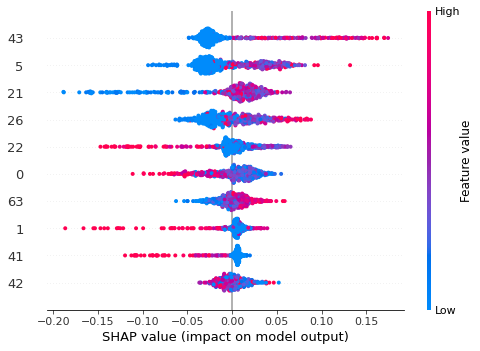

In [133]:
explainer = TreeExplainer(clf)
shap_values = np.array(explainer.shap_values(X_train))


summary_plot(shap_values[0],X_train, max_display=10, show=False)

plt.savefig("ac_summary_plot.png", dpi=300, bbox_inches='tight')



## Difference orient / occident for photochrome
occident = 0

orient = 1

In [138]:
meta[meta['type'] == 'pc']['origin'].value_counts()
data = meta[meta['type'] == 'pc'].groupby(['origin']).apply(lambda s: s.sample(350))
data['filename'].nunique()

700

In [139]:
clf, X_train, feature_list, d = cluster_colors(data, 'origin', 'or_occ_pc.pkl')

training random forest classifier
Accuracy: 0.85


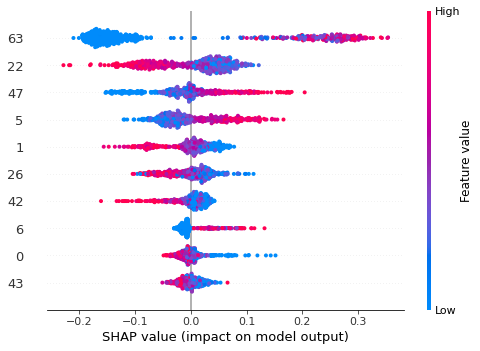

In [147]:
explainer = TreeExplainer(clf)
shap_values = np.array(explainer.shap_values(X_train))


summary_plot(shap_values[0],X_train, max_display=10, show=False)

plt.savefig("pc_summary_plot.png", dpi=300, bbox_inches='tight')

